# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling
Approximate inference targeted at variational Gaussian state-space models with dense covariance matrix approximations.  For more details, see our paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371) \[7\]

This is a walk-through for the minimal functioning of XFADS. We will be building a toy model on the [MC_Maze](https://neurallatents.github.io/datasets.html) dataset as a benchmark, which is a delayed center-out reaching task with barriers.

With the adequate configs, you can fit XFADS on different spans of neural data.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import pytorch_lightning as lightning

from hydra import compose, initialize
from xfads import plot_utils
from xfads.smoothers.lightning_trainers import LightningMonkeyReaching
from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

In [4]:
# ignore future warnings to minimize console output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
torch.cuda.empty_cache()

In [6]:
initialize(version_base=None, config_path="", job_name="monkey_reaching")
cfg = compose(config_name="config")

In [7]:
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1236


# Loading the data
The data is already in the GitHub repo; so it should've been downloaded (in `./data`) with the clone. But if you want to download it manullay, run `download_data.py`. Or you can download it directly from DANDI: [MC_Maze_Medium](https://dandiarchive.org/dandiset/000139).

In [3882]:
data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Data dimensions
n_train_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]
n_time_bins_enc = train_data['n_time_bins_enc']

n_bins_bhv = 10  # at t=n_bins_bhv start forecast
stim_onset = 12  # stimulus onset

trial_list=[1, 287//4, 28//4 + 287//2, 286]

print("# training trials: {0}".format(n_train_trials))
print("# validation trials: {0}".format(n_valid_trials))
print("# testing trials: {0}".format(n_test_trials))
print("# neurons: {0}".format(n_neurons_obs))
print("# time bins: {0}".format(n_time_bins))
print("# time bins used for forcasting: {0}".format(n_bins_bhv))
print("# predicted time bins: {0}".format(n_time_bins_enc))

# training trials: 1721
# validation trials: 287
# testing trials: 287
# neurons: 182
# time bins: 45
# time bins used for forcasting: 10
# predicted time bins: 35


In [3679]:
spike_count = torch.sum(y_valid_obs, axis=1)

In [3681]:
spike_count.shape

torch.Size([287, 182])

In [3682]:
test_data['y_obs'].shape

torch.Size([287, 45, 182])

In [3685]:
spike_count

tensor([[ 2.,  2.,  5.,  ...,  0., 11.,  2.],
        [ 1.,  0.,  1.,  ...,  0.,  7.,  6.],
        [ 1.,  0.,  0.,  ...,  0.,  7.,  5.],
        ...,
        [ 4.,  0.,  0.,  ...,  0.,  8.,  0.],
        [ 8.,  0.,  2.,  ...,  0.,  6., 11.],
        [ 7.,  0.,  1.,  ...,  0.,  7., 10.]])

In [3687]:
def plot_two_d_vector_field(dynamics_fn, axs, min_xy=-3, max_xy=3, n_pts=500, device='cpu'):
    
    with torch.no_grad():
        x = np.linspace(min_xy, max_xy, n_pts)
        y = np.linspace(min_xy, max_xy, n_pts)
        X, Y = np.meshgrid(x, y)

        XY = torch.zeros((X.shape[0]**2, 2))
        XY[:, 0] = torch.from_numpy(X).flatten().to(device)
        XY[:, 1] = torch.from_numpy(Y).flatten().to(device)

        XY_out = dynamics_fn(XY)
        s = XY_out - XY
        u = s[:, 0].reshape(X.shape[0], X.shape[1])
        v = s[:, 1].reshape(Y.shape[0], Y.shape[1])

        axs.streamplot(X, Y, u, v, color='black', linewidth=0.5, arrowsize=0.5)
        
    
def plot_z_samples(fig, axs, samples, color_map_list):
    
    n_samples, n_trials, n_bins, n_neurons = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(stim_onset, linestyle='--', color='gray') for i in range(n_trials)]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    [axs[i].plot(samples[j, i, :, n], color=color_map_list[n](j), linewidth=0.5, alpha=0.4)
     for i in range(n_trials) for j in range(samples.shape[0]) for n in range(n_neurons)]

    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]
    #[axs[i].set_ylim(-12, 12) for i in range(n_trials)]
    
    fig.tight_layout()

In [3689]:
train_data.keys()

dict_keys(['y_obs', 'velocity', 'n_neurons_enc', 'n_neurons_obs', 'n_time_bins_enc'])

In [3691]:
train_data['y_obs'].shape

torch.Size([1721, 45, 182])

# Structuring the State-Space Model

The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods` and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

Note that here we are loading a model that was already trained just by running `train.py` and saving then checkpoints.

In [3694]:
"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
model_ckpt_path = 'results/noncausal_model.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.3
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['best_ssm_enc.nl_filter.dynamics_mod.log_Q', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.weight', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.bias', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.weight', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.bias', 'best_ssm_enc.nl_filter.initial_c_pdf.m_0', 'best_ssm_enc.nl_filter.i

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [3696]:
z_s_train = []
z_s_valid = []
z_f_valid = []
z_p_valid = []
stats_valid = []

for batch in train_dataloader:
    
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    z_s_train.append(z)

for batch in valid_dataloader:
    
    z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0], cfg.n_samples)
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    
    z_p = seq_vae.ssm.predict_forward(z_f[:, :, 10], cfg.n_samples)
    z_p = torch.cat([z_f[:, :, :10], z_p], dim=2)
    
    z_f_valid.append(z_f)
    z_p_valid.append(z_p)
    z_s_valid.append(z)
    stats_valid.append(stats)

In [3697]:
z.shape

torch.Size([25, 287, 45, 40])

In [3698]:
U, S, V = torch.svd(seq_vae.ssm.likelihood_pdf.readout_fn[-1].weight.data)
V = S.unsqueeze(-1) * V

z_s_train = torch.cat(z_s_train, dim=1)
z_s_valid = torch.cat(z_s_valid, dim=1)
z_f_valid = torch.cat(z_f_valid, dim=1)
z_p_valid = torch.cat(z_p_valid, dim=1)

z_s_train = z_s_train[..., :cfg.n_latents_read] @ V
z_s_test = z_s_valid[..., :cfg.n_latents_read] @ V
z_f_test = z_f_valid[..., :cfg.n_latents_read] @ V
z_p_test = z_p_valid[..., :cfg.n_latents_read] @ V

In [3702]:
z_s_valid.shape

torch.Size([25, 287, 45, 40])

In [3704]:
z_p_valid.shape

torch.Size([25, 287, 35, 40])

In [3705]:
z_s_test.shape

torch.Size([25, 287, 45, 35])

In [3708]:
z_p_valid.shape

torch.Size([25, 287, 35, 40])

In [3709]:
z_p_test.shape

torch.Size([25, 287, 35, 35])

In [3710]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_50640/2082696959.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("winter", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_50640/2082696959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = cm.get_cmap("summer", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_50640/2082696959.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  

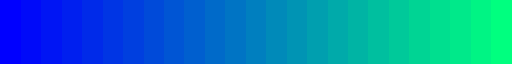

In [3714]:
blues

Plotting top 3 principal latent dimensions of 4 trials per regime.

The vertical black line is the movement onset, and the red line is where the prediction by xfads starts.

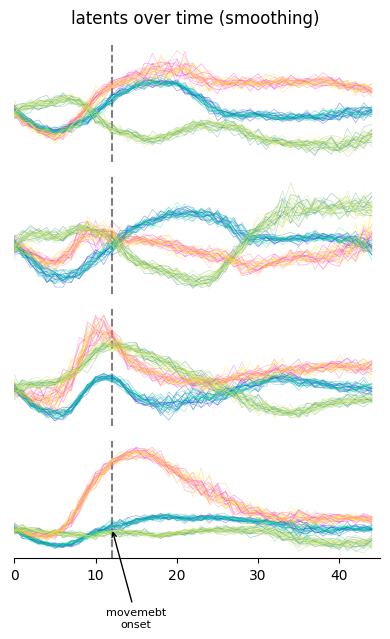

In [3717]:
"""smoothed"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_samples(fig, axs, z_s_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('latents over time (smoothing)')
    fig.tight_layout()
    
    plt.annotate('movemebt\nonset', xy=(12, 0), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/z_s_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

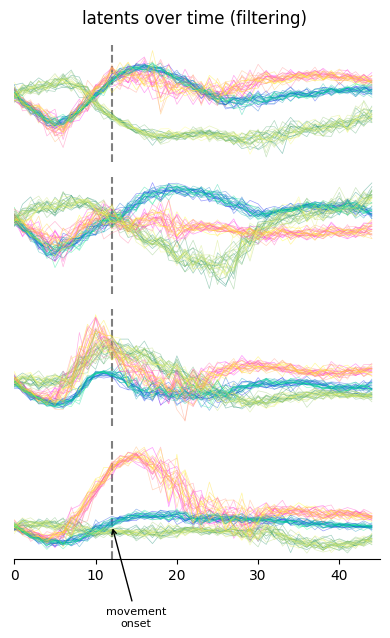

In [3719]:
"""filtered"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_samples(fig, axs, z_f_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n(filtering regime) \n')
    fig.suptitle('latents over time (filtering)')
    fig.tight_layout()
    
    plt.annotate('movement\nonset', xy=(12, 0), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/z_f_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

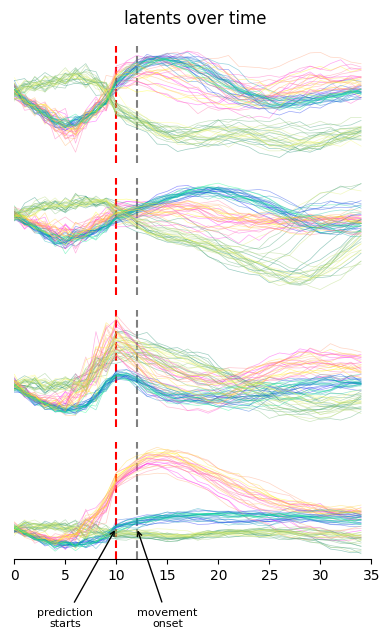

In [3721]:
"""predicted"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_list))]
    plot_z_samples(fig, axs, z_p_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n(prediction regime) \n')
    fig.suptitle('latents over time')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, 0), xytext=(5, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.annotate('movement\nonset', xy=(12, 0), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/z_p_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

# Evaluating Model Performance
The most trivial way to start with is just to plot the training and validation losses. Good we have the logs!

In [36]:
# reading the logs

logs_path = 'logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal/metrics.csv'
metrics = pd.read_csv(logs_path).to_dict()

In [37]:
metrics.keys()

dict_keys(['epoch', 'r2_test_bhv', 'r2_test_enc', 'r2_train_enc', 'r2_valid_bhv', 'r2_valid_enc', 'step', 'test_bps_bhv', 'test_bps_enc', 'test_loss', 'time_forward', 'train_bps_enc', 'train_loss', 'valid_bps_bhv', 'valid_bps_enc', 'valid_loss'])

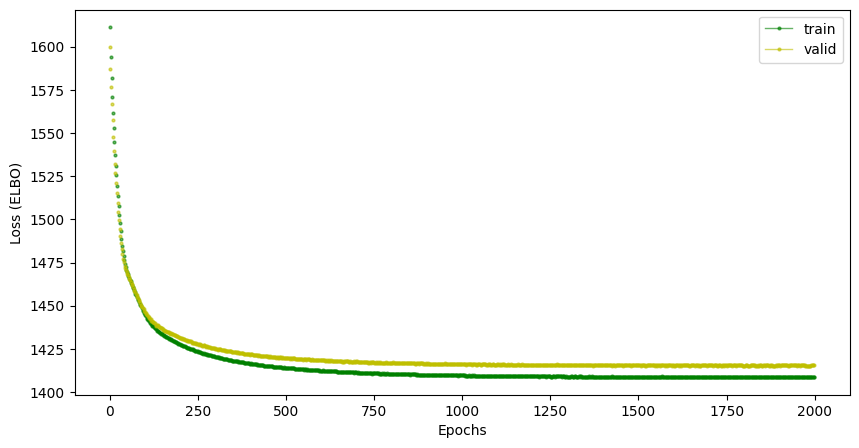

In [38]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_loss'].keys(),
    metrics['train_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_loss'].keys(),
    metrics['valid_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (ELBO)')

plt.legend()

plt.savefig('plots/loss.png', bbox_inches='tight', transparent=True)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


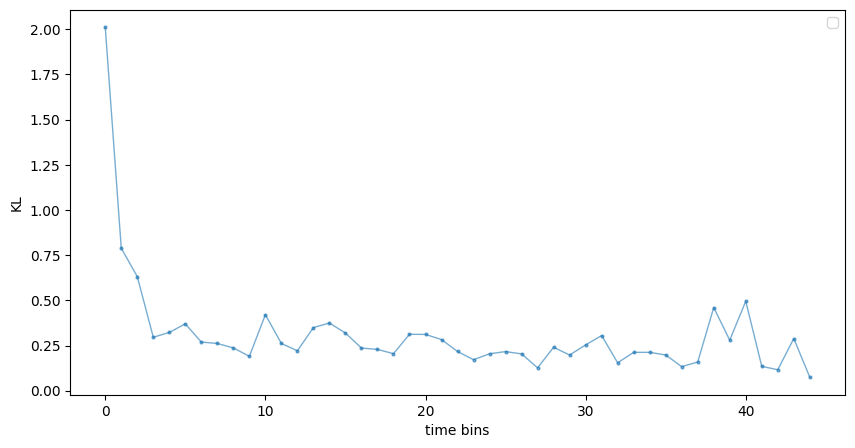

In [39]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

with torch.no_grad():
    plt.plot(
        stats['kl'][286],
        marker='o', markersize=2, linestyle='-', alpha=0.6, linewidth=1)

plt.xlabel('time bins')
plt.ylabel('KL')

plt.legend()
plt.show()

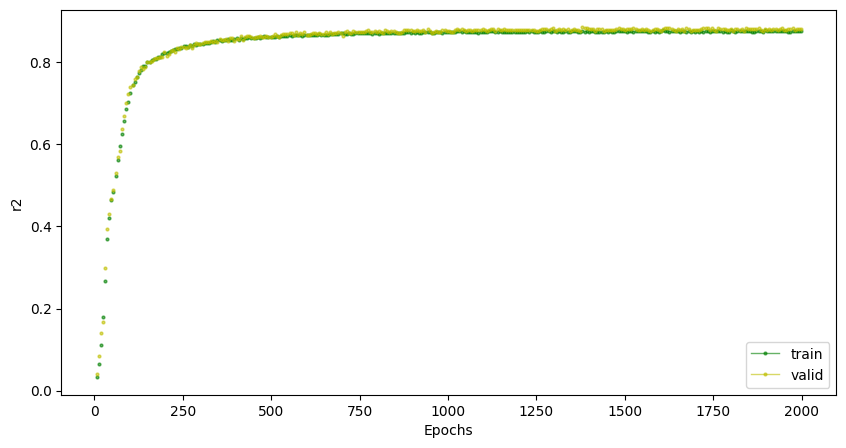

In [40]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    list(metrics['r2_train_enc'].keys())[1:],
    list(metrics['r2_train_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    list(metrics['r2_valid_enc'].keys())[1:],
    list(metrics['r2_valid_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('R2')

plt.xlabel('Epochs')
plt.ylabel('r2')

plt.legend()

plt.savefig('plots/r2.png', bbox_inches='tight', transparent=True)

plt.show()

Another way to evaluate model performance is the **Bits per Spike (BpS)**. Which is a quantification of how neurons encode information.

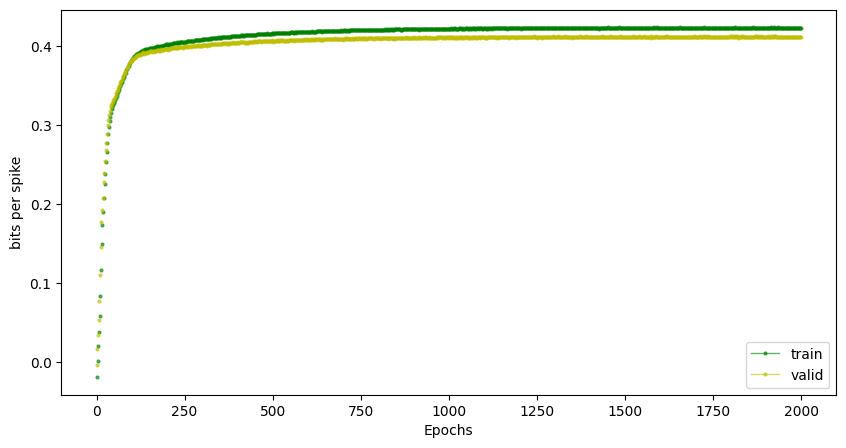

In [42]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_bps_enc'].keys(),
    metrics['train_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_bps_enc'].keys(),
    metrics['valid_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('Bits per Spike for Training and Validation')

plt.xlabel('Epochs')
plt.ylabel('bits per spike')

plt.legend()

plt.savefig('plots/bps.png', bbox_inches='tight', transparent=True)

plt.show()

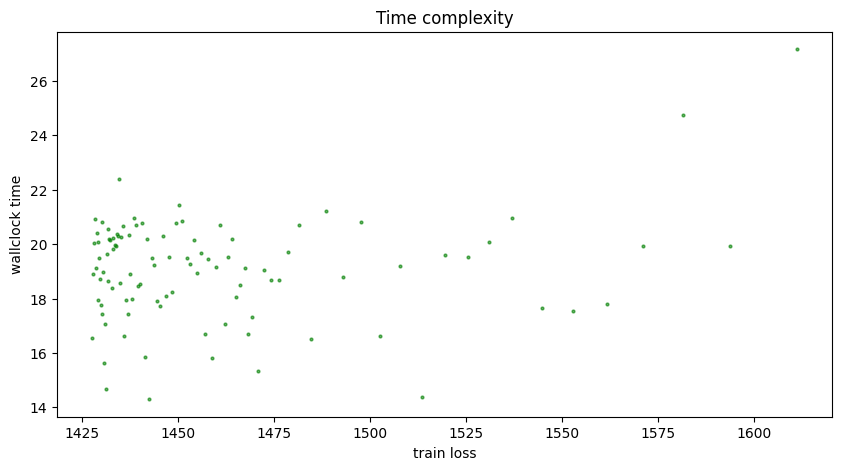

In [43]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    list(metrics['train_loss'].values())[:200],
    list(metrics['time_forward'].values())[:200],
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1)

plt.title('Time complexity')

plt.xlabel('train loss')
plt.ylabel('wallclock time')

plt.show()

The previous plots were all about the evolution of the model performance throughout training (loss x epochs). Aonther way to evaluate how the model captures the tuning properties of neurons relative to the stimulus over time is to look at the **peri-stimulus time histogram (PSTH)**.

We will generate condition averaged (in our example, conditions are the reaching directions) PSTHs from the model and compare them to the condition averaged PSTHs from the data.

In [45]:
def compute_psth(spikes, conditions, time_bins, condition):
    
    psth = np.zeros(len(time_bins) - 1)
    count = 0
    
    for trial_spikes, trial_condition in zip(spikes, conditions):
        if trial_condition == condition:
            hist, _ = np.histogram(trial_spikes, bins=time_bins)
            psth += hist
            count += 1
    psth /= count  # Average over trials
    
    return psth

In [46]:
z_f_test.shape

torch.Size([25, 287, 45, 35])

In [47]:
z_s_test[0, 0, 0, :]

tensor([-0.0057,  4.8801, -0.0588, -0.2108,  0.9468,  0.1563, -0.1525, -0.7784,
        -1.6968,  0.8882,  0.8494,  2.4390, -0.6269, -0.3695,  0.5476, -0.6206,
        -0.9421,  1.2051,  0.4942,  0.4771, -1.2105,  0.8328, -1.0750, -0.8439,
         0.4365,  0.8818,  0.6194, -0.2196,  0.1224,  1.5225,  0.6679, -0.3772,
        -0.1296, -0.1689,  1.3537], grad_fn=<SliceBackward0>)

In [48]:
stats.keys()

dict_keys(['m_f', 'kl', 't_mask_y_in'])

In [49]:
stats['kl'].shape

torch.Size([287, 45])

In [50]:
len(y_test_dataset)

287

In [51]:
y_valid_obs.shape

torch.Size([287, 45, 182])

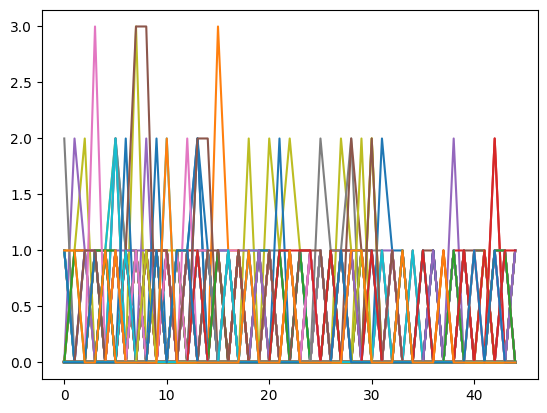

In [52]:
plt.plot(y_valid_obs[trial])

# Breaking down the state space model leaned by XFADS

One of the main functionalities of XFADS is breaking the amortized inference step into two additive components: the `local_encoder` and the `backward_encoder`.

In [56]:
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [57]:
likelihood_pdf = seq_vae.ssm.likelihood_pdf
dynamics_mod = seq_vae.ssm.dynamics_mod
local_encoder = seq_vae.ssm.local_encoder
backward_encoder = seq_vae.ssm.backward_encoder

In [58]:
seq_vae.ssm.local_encoder

LocalEncoderLRMvn(
  (mlp): Sequential(
    (0): Linear(in_features=182, out_features=256, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=640, bias=True)
  )
)

In [59]:
stats_dict = torch.load('results/noncausal_model.ckpt', map_location=torch.device('cpu'))

In [61]:
"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
model_ckpt_path = 'results/noncausal_model.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.3
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['best_ssm_enc.nl_filter.dynamics_mod.log_Q', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.weight', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.bias', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.weight', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.bias', 'best_ssm_enc.nl_filter.initial_c_pdf.m_0', 'best_ssm_enc.nl_filter.i

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [62]:
seq_vae.ssm.local_encoder = seq_vae.ssm.local_encoder.to(cfg.device)
seq_vae.ssm.local_encoder.eval()

LocalEncoderLRMvn(
  (mlp): Sequential(
    (0): Linear(in_features=182, out_features=256, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=640, bias=True)
  )
)

In [63]:
z_s_valid.shape

torch.Size([25, 287, 45, 40])

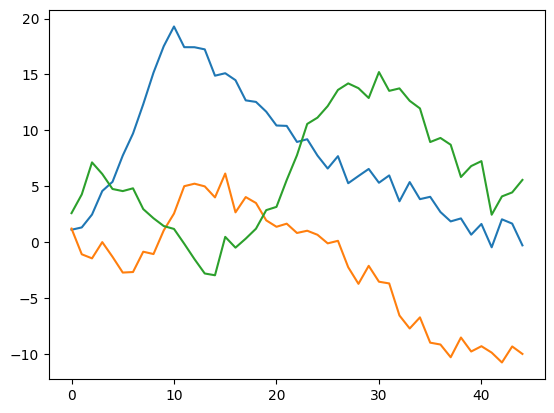

In [64]:
with torch.no_grad():
    plt.plot(z_s_valid[0, 0, :, :3])

In [67]:
stats_dict['state_dict']['ssm.local_encoder.mlp.0.weight'].shape

torch.Size([256, 182])

In [68]:
z_s_test.shape

torch.Size([25, 287, 45, 35])

In [69]:
z_s_test[:, 0, 0, 0].min()

tensor(-0.6858, grad_fn=<MinBackward1>)

In [73]:
torch.mean(z_s_test[:, -1, ..., :], dim=0).shape

torch.Size([45, 35])

In [74]:
(torch.sum(z_s_test[:, -1, ..., :], dim=0)/25)

tensor([[ 1.1678,  4.2653,  0.6054,  ..., -0.0146, -0.2836,  0.2667],
        [ 1.8820,  6.6718,  1.9688,  ..., -1.7673,  0.2764, -1.1981],
        [ 1.9086,  7.7270,  2.5019,  ..., -2.8657,  0.1309, -1.9587],
        ...,
        [ 7.8396, -0.1029,  0.3175,  ...,  0.1277, -4.0684,  2.8597],
        [ 7.6629,  0.3753,  0.1387,  ..., -0.0116, -4.1425,  2.7333],
        [ 8.1139,  0.9674,  0.5796,  ...,  0.0125, -3.7351,  2.7187]],
       grad_fn=<DivBackward0>)

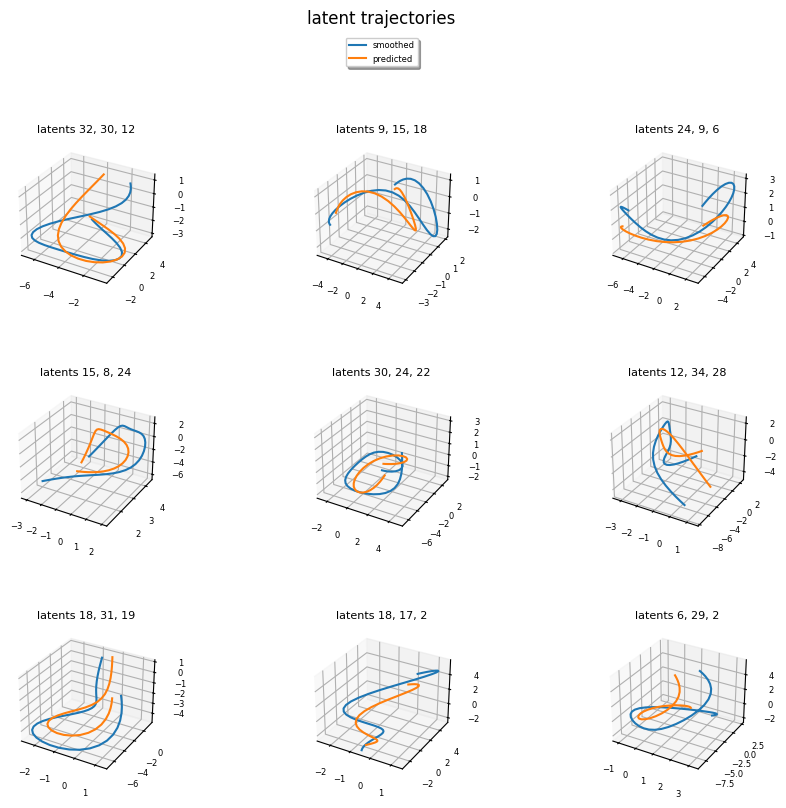

In [3252]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_unique_random_ints(mn, mx, n):
    
    unique_numbers = []
    
    while len(unique_numbers) < n:
        number = random.randint(mn, mx)
        
        if number not in unique_numbers:
            unique_numbers.append(number)
            
    return unique_numbers


with torch.no_grad():

    fig, axes = plt.subplots(3, 3, figsize=(10, 8), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    fig.suptitle('latent trajectories\n\n\n\n')
    
    n_latents_to_plot = 3
    
    for i, ax in enumerate(axes.flat):
        
        # latents = [random.randint(1, cfg.n_latents_read) for _ in range(3)]
        latent1, latent2, latent3 = generate_unique_random_ints(0, cfg.n_latents_read - 1, n_latents_to_plot)
        
        # Select three latent dimensions for 3D plotting
        x = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., latent1-1], dim=0), sigma=4, axis=0))
        y = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., latent2-1], dim=0), sigma=4, axis=0))
        z = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., latent3-1], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label='smoothed' if i == 0 else '')
        
        x_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, 0, ..., latent1-1], dim=0), sigma=4, axis=0))
        y_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, 0, ..., latent2-1], dim=0), sigma=4, axis=0))
        z_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, 0, ..., latent3-1], dim=0), sigma=4, axis=0))
        
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.tick_params(axis='z', labelsize=6)
        
        ax.plot(x_p, y_p, z_p, label='predicted' if i == 0 else '')
        
        ax.set_title(f'latents {latent1}, {latent2}, {latent3}', fontsize=8)
        #ax.set_xlabel(f'latent {latent1}', fontsize=8)
        #ax.set_ylabel(f'latent {latent2}', fontsize=8)
        #ax.set_zlabel(f'latent {latent3}', fontsize=8)
    
    plt.tight_layout()
    # Adjust spacing between subplots
    fig.subplots_adjust(hspace=0.6)  # Increase spacing between subplots
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), shadow=True, ncol=1, fontsize=6)

    fig.savefig('plots/3d_trajectory.png', bbox_inches='tight', transparent=True)
    
    plt.show()


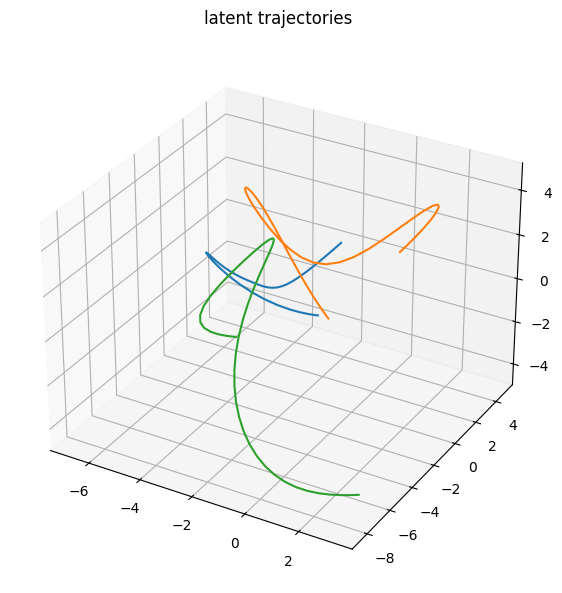

In [3254]:
with torch.no_grad():

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    fig.suptitle('latent trajectories')
    
    n_latents_to_plot = 3
    n_trajectories_to_plot = 3
    
    top_latents = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., 0:3], dim=0), sigma=4, axis=0))
    
    for i in range(n_trajectories_to_plot):
        
        latent1, latent2, latent3 = generate_unique_random_ints(0, cfg.n_latents_read - 1, n_latents_to_plot)

        # Select three latent dimensions for 3D plotting
        x = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., latent1-1], dim=0), sigma=4, axis=0))
        y = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., latent2-1], dim=0), sigma=4, axis=0))
        z = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, 0, ..., latent3-1], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z)

    #ax.set_title(f'latents {latent1+1}, {latent2+1}, {latent3+1}', fontsize=8)
    #ax.set_xlabel(f'latent {latent1}', fontsize=8)
    #ax.set_ylabel(f'latent {latent2}', fontsize=8)
    #ax.set_zlabel(f'latent {latent3}', fontsize=8)
    
    plt.tight_layout()
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase spacing between subplots

    fig.savefig('plots/3d_trajectory_in_one_fig.png', bbox_inches='tight', transparent=True)
    
    plt.show()


In [2390]:
top_latents.shape

torch.Size([45, 3])

In [2326]:
generate_unique_random_ints(0, 35, 3)

[25, 16, 10]

In [1260]:
torch.mean(z_s_test[:, -1, ..., 2], dim=0).T.shape

torch.Size([45])

In [77]:
torch.mean(torch.mean(z_s_test[:, :, ..., 2], dim=0), dim=1).shape

torch.Size([287])

In [78]:
torch.mean(z_s_test[:, :, ..., 2], dim=0).shape

torch.Size([287, 45])

In [79]:
torch.mean(torch.mean(z_s_test[:, :, ..., 0], dim=0), dim=0).shape

torch.Size([45])

In [80]:
    torch.mean(z_s_test[:, :, ..., -1], dim=0).shape

torch.Size([287, 45])

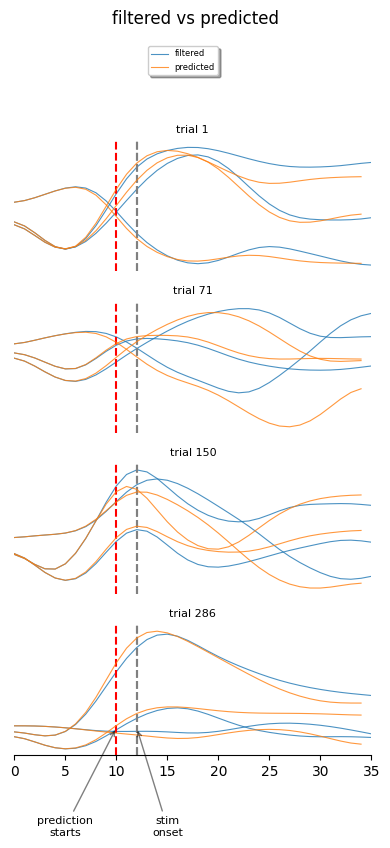

In [3256]:
def plot_z_overlayed(fig, axs, trial_list, samples, color, regime):
    
    n_samples, n_trials, n_bins, n_neurons = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(stim_onset, linestyle='--', color='gray') for i in range(n_trials)]
    
    if regime == 'predicted':
        [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_list))]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    [axs[i].set_title(f'trial {trial_list[i]}', fontsize=8) for i in range(n_trials)]
    
    [axs[i].plot(torch.tensor(gaussian_filter1d(torch.mean(samples[:, i, :, n], dim=0), sigma=2, axis=0)), color=color, linewidth=0.8, alpha=0.8, label=regime if i == 0 and n == 0 else '')
     for i in range(n_trials) for n in range(n_neurons)]

    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]
    #[axs[i].set_ylim(-12, 12) for i in range(n_trials)]
    
    fig.tight_layout()

    
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 8))
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plot_z_overlayed(fig, axs, trial_list, z_f_test[:, trial_list, ..., -3:], color=default_colors[0], regime='filtered')
    plot_z_overlayed(fig, axs, trial_list, z_p_test[:, trial_list, ..., -3:], color=default_colors[1], regime='predicted')
    
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('filtered vs predicted\n\n\n\n')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, 0), xytext=(5, -20),
             arrowprops=dict(facecolor='gray', arrowstyle='->', alpha=0.5),
             fontsize=8, ha='center')
    
    plt.annotate('stim\nonset', xy=(12, 0), xytext=(3+12, -20),
             arrowprops=dict(facecolor='gray', arrowstyle='->', alpha=0.5),
             fontsize=8, ha='center')
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.47, 0.94), shadow=True, ncol=1, fontsize=6)
    
    fig.savefig('plots/f_vs_p.png', bbox_inches='tight', transparent=True)
    
    plt.show()

In [88]:
z_s_test.shape

torch.Size([25, 287, 45, 35])

In [90]:
z_f_test.shape

torch.Size([25, 287, 45, 35])

In [91]:
z_p_test.shape

torch.Size([25, 287, 35, 35])

In [95]:
y_train_obs.shape

torch.Size([1721, 45, 182])

In [3258]:
def plot_spikes(spikes, axs):
    
    n_bins = spikes.shape[0]
    n_neurons = spikes.shape[1]

    # fig, axs = plt.subplots(figsize=(6, 3))
    _, indices = torch.sort(spikes.mean(dim=0))
    spikes = spikes[:, indices][..., n_neurons//2:]
    n_neurons = n_neurons//2

    for n in range(n_neurons):
        time_ax = np.arange(n_bins)
        neuron_spikes = spikes[:, n]
        neuron_spikes[neuron_spikes > 0] = 1
        neuron_spikes = neuron_spikes * time_ax
        neuron_spikes = neuron_spikes[neuron_spikes > 0]

        axs.scatter(neuron_spikes, 0.5 * n * np.ones_like(neuron_spikes), marker='o', color='black', s=4,
                    edgecolors='none')

# Generating corresponding observations
We can use the likelifood function (observation model) to generate new data (log rates) from the latents.

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_50640/2018033648.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


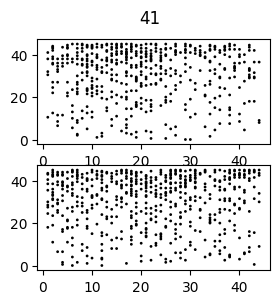

In [3773]:
# smoothed and predicted log rates
r_s = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_s_test)
r_p = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_p_test)
# sampeling from the rates possion to get the spike counts
y_s = torch.poisson(cfg.bin_sz * torch.exp(r_s))
y_p = torch.poisson(cfg.bin_sz * torch.exp(r_p))

y_hat = torch.cat([y_s[:, :, :n_bins_bhv], y_p], dim=2)
z_hat = torch.cat([z_s_test[:, :, :n_bins_bhv, :], z_p_test], dim=2)
i = 41

# Enable interactive mode
plt.ion()

with torch.no_grad():
    fig, axs = plt.subplots(2, 1, figsize=(3, 3))
    plot_utils.plot_spikes(y_test_obs[i].cpu(), axs[0])
    plot_utils.plot_spikes(y_hat[0, i], axs[1])

    fig.suptitle(i)
    fig.savefig('plots/generated_spikes.svg', bbox_inches='tight', transparent=True)
    fig.show()

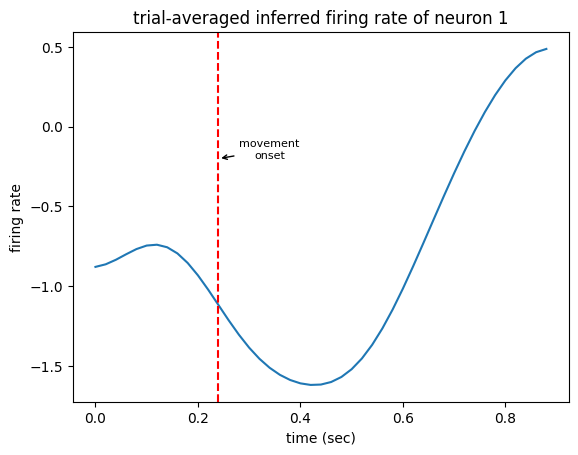

In [3775]:
 with torch.no_grad():
    #plt.plot(r_s[0, 0, :, :1])
    plt.plot(np.arange(n_bins) * bin_size, torch.tensor(gaussian_filter1d(torch.mean(r_s[0, :, :, 12], axis=0), sigma=4, axis=0)))
    plt.title('trial-averaged inferred firing rate of neuron 1')
    plt.xlabel('time (sec)')
    plt.ylabel('firing rate')
    plt.axvline(x=stim_onset*bin_size, color='r', linestyle='--')
    plt.annotate('movement\nonset', xy=(stim_onset*bin_size, -0.2), xytext=(stim_onset*bin_size+0.1, -0.2),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center')
    plt.savefig('plots/r_s.png')

In [119]:
r_p.shape

torch.Size([25, 287, 35, 182])

In [4057]:
num_neurons

10

In [4132]:
def plot_rastor(data, latents, trial_list=[0, 287//4, 28//4 + 287//2, 286], regime='real', top_n_neurons=n_neurons_obs, order=False):
    
    data = data.clone()
    latents = latents.clone()
    
    if order == True:
        
        for trial in trial_list:
            # Get the indices of the ordered neurons based on their contribution to the first principle latent dimension
            ordered_correlations, ordered_neurons = order_neurons(data, latents, trial=trial, latent=0)
            # just reorder the neurons in the trials we want to plot.
            data[trial] = data[trial, :, ordered_neurons-1]
        
    with torch.no_grad():

        plt.figure(figsize=(16, 6))
        
        n_trials_to_plot = 4

        fig, axes = plt.subplots(ncols=n_trials_to_plot, figsize=(16, 6))
        fig.suptitle('generated trials' if regime in ['filtering', 'smoothing', 'prediction'] else 'real trials')
        
        vmin, _ = torch.min(data[trial_list].flatten(), dim=0)
        vmax, _ = torch.max(data[trial_list].flatten(), dim=0)

        for ax, trial in zip(axes, trial_list):

            cax = ax.imshow(data[trial].T[:top_n_neurons], cmap='viridis', interpolation='none', aspect='auto')
            
            cbar = fig.colorbar(cax, ax=ax, shrink=0.2)
            cbar.mappable.set_clim(vmin=vmin, vmax=vmax)
            if fig.get_axes().index(ax) == 0:
                cbar.set_label('spike counts')
                
            ax.set_title(f'trial {trial+1}', fontsize=10)
            
            x_ticks = ax.get_xticks()
            x_labels = x_ticks * cfg.bin_sz_ms
            ax.set_xticks(x_ticks, x_labels)
            
            ax.set_xlim(0, n_time_bins)
            
            ax.spines['right'].set_visible(False)
            
            if regime == 'prediction':
                ax.axvline(x=n_bins_bhv, color='y', linestyle='--')  # Mark prediction start
            ax.axvline(x=stim_onset, color='r', linestyle='--')  # Mark stimulus onset
            
            '''
            if trial==trial_list[0]:
                
                if regime == 'prediction':
                    ax.annotate('pred\nstarts', xy=(n_bins_bhv, 0), xytext=(11-5-3, -20),
                         arrowprops=dict(facecolor='black', arrowstyle='->'),
                         fontsize=8, ha='center')
            
                ax.annotate('move\nonset', xy=(stim_onset, 0), xytext=(11+5, -20),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center')
        '''
        #  make the y-axis unvisible exept for the first plot.
        [axes[i].yaxis.set_visible('false') for i in range(1, n_trials_to_plot)]
        [axes[i].set_yticks([]) for i in range(1, n_trials_to_plot)]
        
        axes[0].set_xlabel('time (ms)')
        axes[0].set_ylabel('neurons' if order == False else 'ordered neurons')
        
        fig.tight_layout()
        
        #file = 'plots/real.png' if regime == 'real' else 'plots/generated.png'
        file = 'real_ordered_top_50.png'
        fig.savefig(file, bbox_inches='tight', transparent=True)

        plt.show()

<Figure size 1600x600 with 0 Axes>

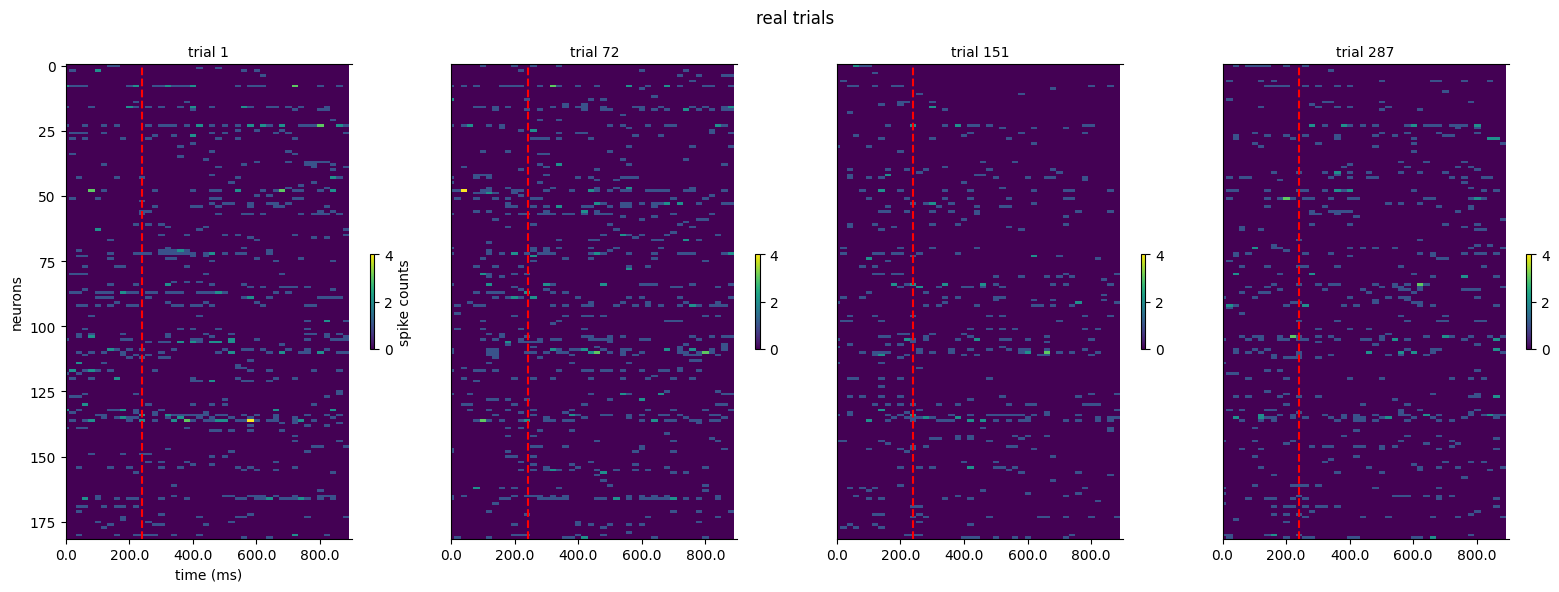

In [4127]:
trial_list=[0, 287//4, 28//4 + 287//2, 286]

plot_rastor(y_valid_obs, z_s_test, trial_list, order=False)

<Figure size 1600x600 with 0 Axes>

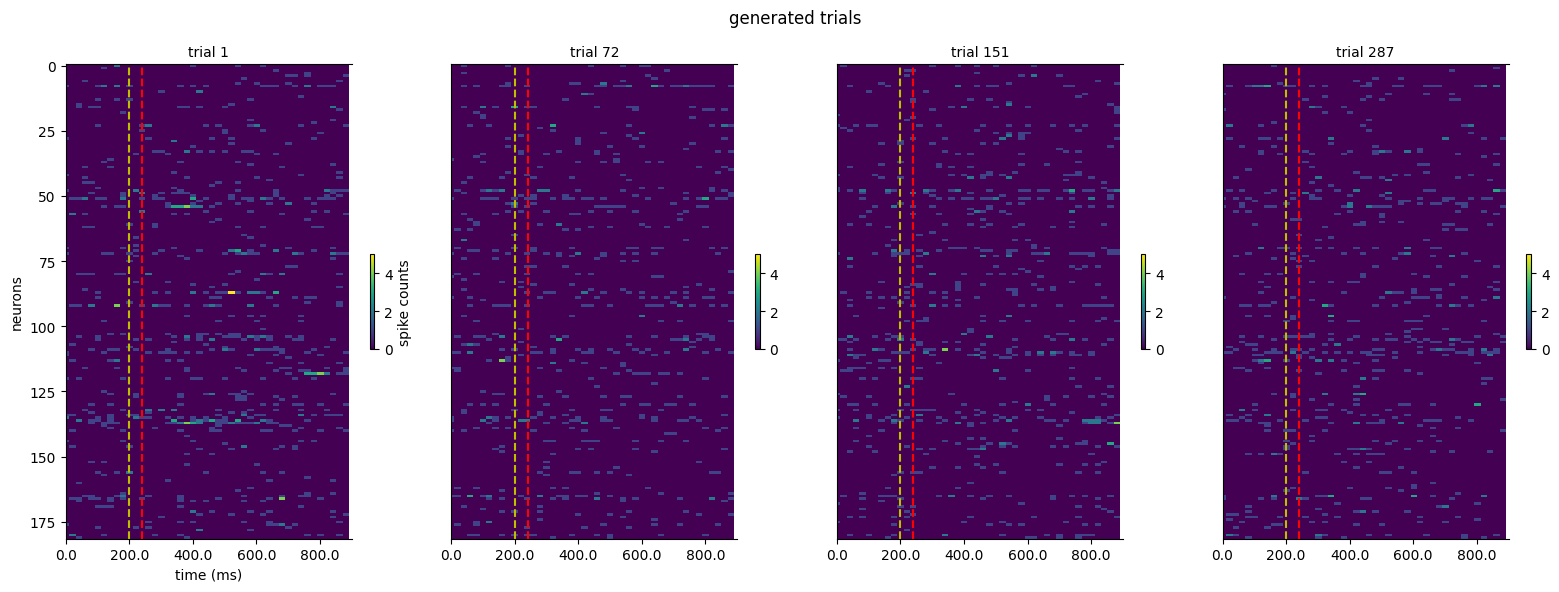

In [4063]:
plot_rastor(y_hat[0], z_s_test, trial_list, regime='prediction')

generated : sampels x trials x time bins x neurons

real     : trials x time bins x neurons

## Ordering the neurons in terms of their loading to the 1st principal latent dimension

In [4146]:
def order_neurons(trials, latents, trial, latent):

    with torch.no_grad():

        trial_to_reorder = trials[trial]
        latent_to_compare = torch.mean(latents[:, 0, :, latent], dim=0)

        # Check for NaN or infinite values and clean the data if necessary
        trial_to_reorder = np.nan_to_num(trial_to_reorder, nan=0.0, posinf=0.0, neginf=0.0)
        latent_to_compare = np.nan_to_num(latent_to_compare, nan=0.0, posinf=0.0, neginf=0.0)

        def calc_corrcoef(x, y):
            with np.errstate(divide='ignore', invalid='ignore'):
                corr = np.corrcoef(x, y)[0, 1]
            if np.isnan(corr):
                return 0.0
            return corr

        correlations = np.array([calc_corrcoef(trial_to_reorder[:, i], latent_to_compare) for i in range(trial_to_reorder.shape[1])])

        correlation_df = pd.DataFrame({'neuron': range(1, trial_to_reorder.shape[1] + 1), 'correlation': correlations})

        # Order the DataFrame by the absolute value of correlations
        ordered_correlation_df = correlation_df.reindex(correlation_df.correlation.abs().sort_values(ascending=False).index)

        return ordered_correlation_df.to_numpy(), ordered_correlation_df.to_numpy().T[0]

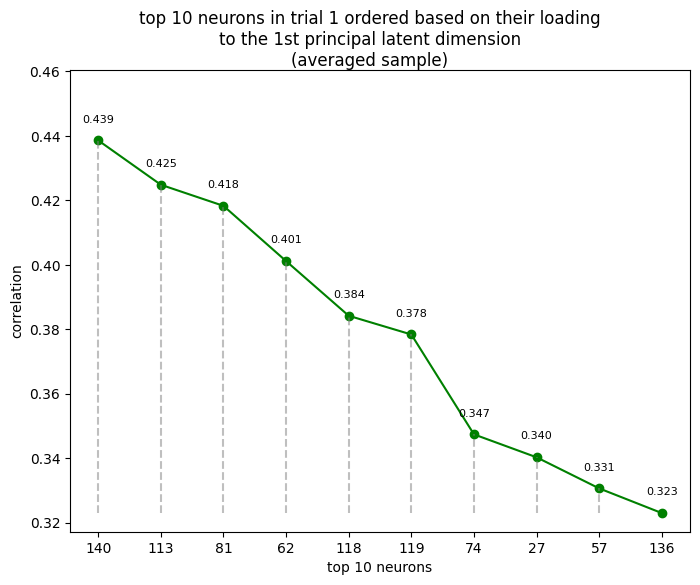

In [4150]:
ordered_correlations, ordered_neurons = order_neurons(y_valid_obs, z_s_test, trial=0, latent=0)

time_bins = [str(i) for i in ordered_neurons[:10].astype('int32')]

y = np.abs(ordered_correlations.T[1][:10])

plt.ion()

fig, axes = plt.subplots(figsize=(8, 6))

axes.plot(time_bins, y, marker='o', linestyle='-', color='g')

for i in range(len(time_bins)):
    plt.text(time_bins[i], y[i]+0.005, f'{y[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.vlines(i, ymin=y.min(), ymax=y[i], linestyles='dashed', colors='gray', alpha=0.5)

fig.suptitle('top 10 neurons in trial 1 ordered based on their loading\nto the 1st principal latent dimension\n(averaged sample)\n\n\n\n')
plt.ylim(top=y.max()+0.05*y.max())

plt.xlabel('top 10 neurons')
plt.ylabel('correlation')

plt.show()
fig.savefig('plots/corrcoef(averaged_samples).png')

<Figure size 1600x600 with 0 Axes>

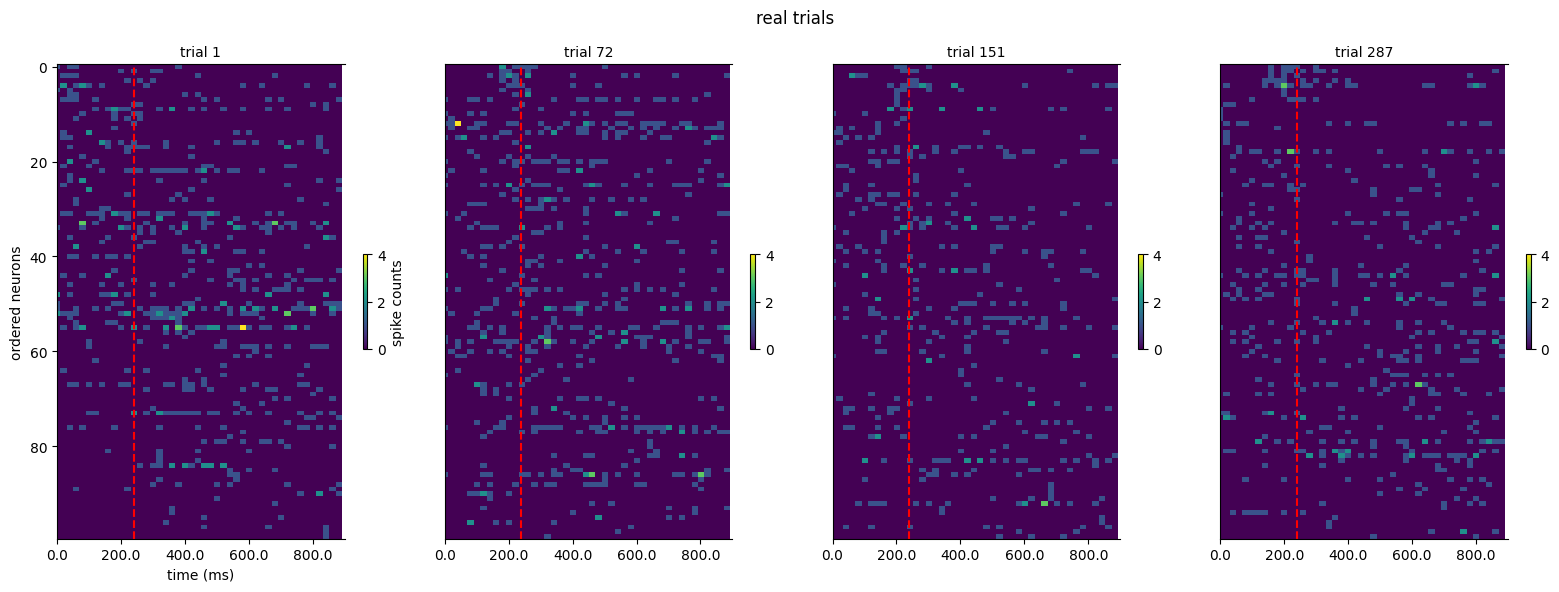

In [4136]:
plot_rastor(y_valid_obs, z_s_test, trial_list, top_n_neurons=100, order=True)

<Figure size 1600x600 with 0 Axes>

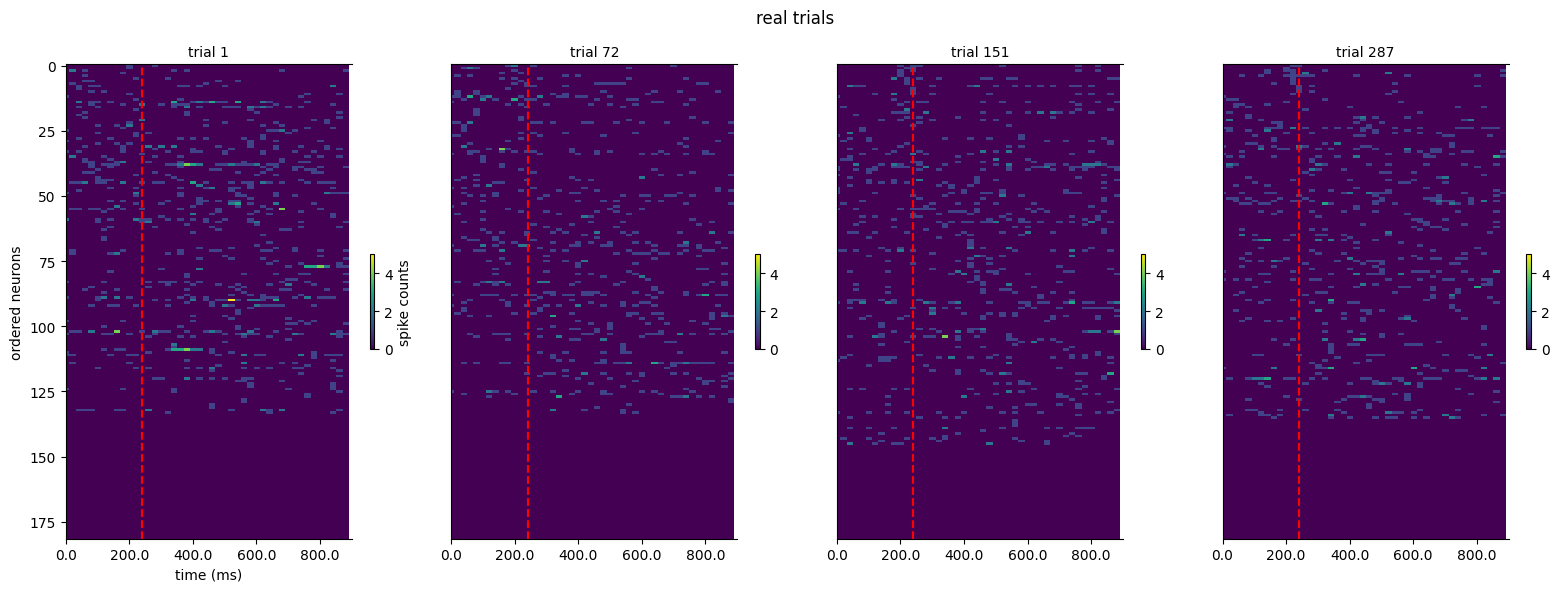

In [4075]:
plot_rastor(y_hat[0], z_s_test, trial_list, order=True)

## Plotting the firing rates of both real and generated trials

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_50640/1048794176.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


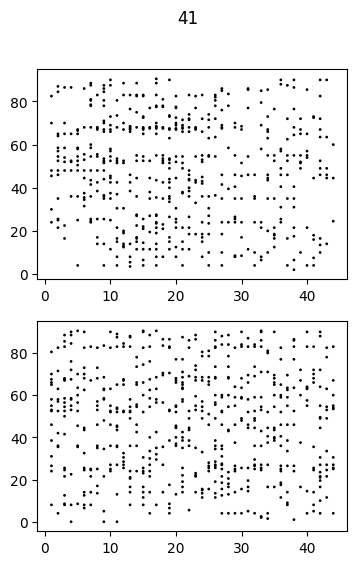

In [591]:
def plot_spikess(spikes, axs):
    n_bins = spikes.shape[0]
    n_neurons = spikes.shape[1]

    # fig, axs = plt.subplots(figsize=(6, 3))
    _, indices = torch.sort(spikes.mean(dim=0))
    #spikes = spikes[:, indices][..., n_neurons//2:]
    #n_neurons = n_neurons//2

    for n in range(n_neurons):
        time_ax = np.arange(n_bins)
        neuron_spikes = spikes[:, n]
        neuron_spikes[neuron_spikes > 0] = 1
        neuron_spikes = neuron_spikes * time_ax
        neuron_spikes = neuron_spikes[neuron_spikes > 0]

        axs.scatter(neuron_spikes, 0.5 * n * np.ones_like(neuron_spikes), marker='o', color='black', s=4,
                    edgecolors='none')

with torch.no_grad():

    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    plot_spikess(y_test_obs[i].cpu(), axs[0])
    plot_spikess(y_hat[0, i], axs[1])

    fig.suptitle(i)
    fig.savefig('plots/generated_spikes.svg', bbox_inches='tight', transparent=True)
    fig.show()

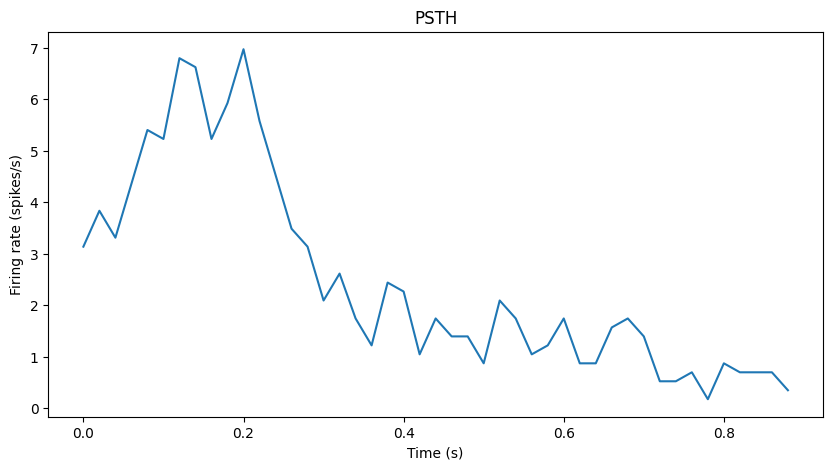

In [851]:
import numpy as np
import matplotlib.pyplot as plt


n_bins = n_time_bins
bin_size = cfg.bin_sz  # Assuming bin size of 10 ms

# trials x time bins
single_neuron = y_test_obs[:, :, 50]

# Calculate the PSTH by averaging across trials
psth = torch.mean(single_neuron, axis=0) / bin_size

# Create a time vector for plotting
time_bins = np.arange(n_bins) * bin_size

# Plot the PSTH
plt.figure(figsize=(10, 5))
plt.plot(time_bins, psth)

plt.xlabel('Time (s)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('PSTH')
plt.show()

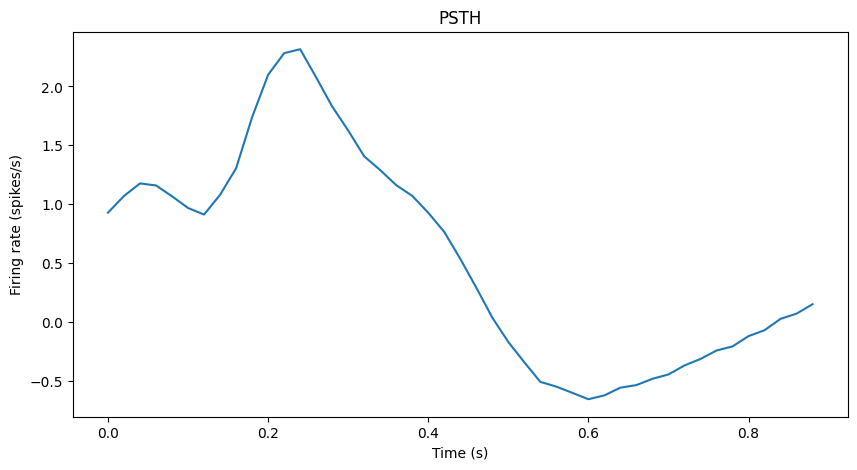

In [1264]:
with torch.no_grad():
    n_bins = n_time_bins
    bin_size = cfg.bin_sz  # Assuming bin size of 10 ms

    # trials x time bins
    single_neuron = r_s[0, :, :, 0]

    # Calculate the PSTH by averaging across trials
    psth = torch.mean(single_neuron, axis=0)

    # Create a time vector for plotting
    time_bins = np.arange(n_bins) * bin_size

    # Plot the PSTH
    plt.figure(figsize=(10, 5))
    plt.plot(time_bins, psth)

    plt.xlabel('Time (s)')
    plt.ylabel('Firing rate (spikes/s)')
    plt.title('PSTH')
    plt.show()

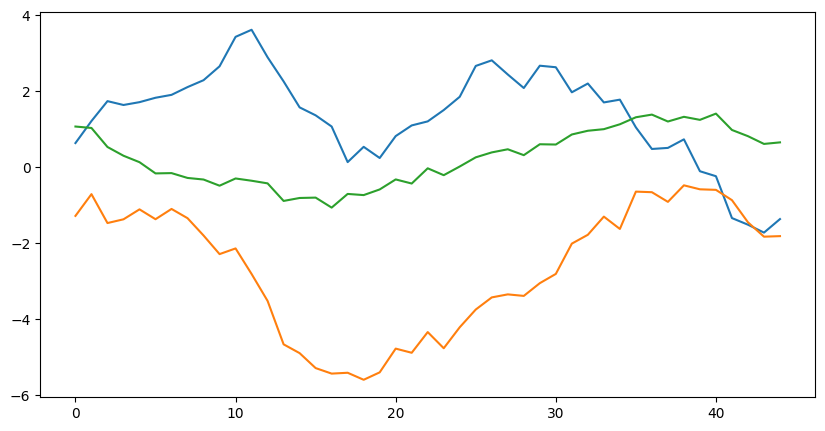

In [867]:
with torch.no_grad():

    # Plot the PSTH
    plt.figure(figsize=(10, 5))
    plt.plot(r_s[0, 0, :, :3])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_firing_rates(data, num_neurons=n_neurons_obs):

    # Assume each time bin represents 10 milliseconds (0.01 seconds)
    bin_duration_sec = 20e-3

    # Calculate the firing rate as spikes per second for each neuron
    firing_rates_per_sec = data / bin_duration_sec

    # Plot the firing rate of each neuron over time
    plt.figure(figsize=(12, 8))
    for neuron in range(1):
        plt.plot(firing_rates_per_sec[neuron])

    plt.xlabel('Time Bin')
    plt.ylabel('Firing Rate (spikes/second)')
    plt.title('Firing Rates of Individual Neurons Over Time')
    plt.show()

    # Heatmap of the spike data
    plt.figure(figsize=(12, 6))
    sns.heatmap(data, cmap='viridis', cbar=False)
    plt.xlabel('Time Bin')
    plt.ylabel('Neuron')
    plt.title('Spike Data Heatmap')
    plt.show()


In [754]:
binned_spikes.shape

(10, 60)

In [768]:
single_neuron.shape

torch.Size([287, 45])

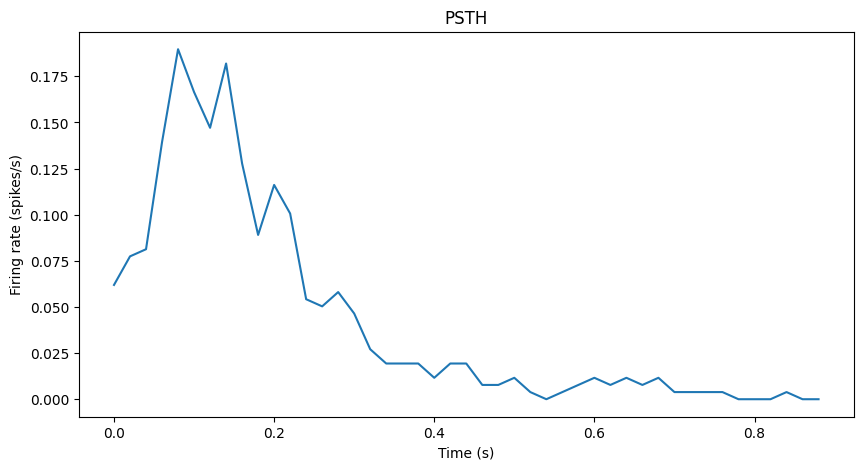

In [1270]:
import numpy as np
import matplotlib.pyplot as plt


n_bins = n_time_bins
bin_size = cfg.bin_sz  # Assuming bin size of 10 ms

# trials x time bins
single_neuron = y_test_obs[:, :, 0]

# Calculate the PSTH by averaging across trials
psth = torch.mean(single_neuron, axis=0) / (bin_size * n_bins)

# Create a time vector for plotting
time_bins = np.arange(n_bins) * bin_size

# Plot the PSTH
plt.figure(figsize=(10, 5))
plt.plot(time_bins, psth)

plt.xlabel('Time (s)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('PSTH')
plt.show()

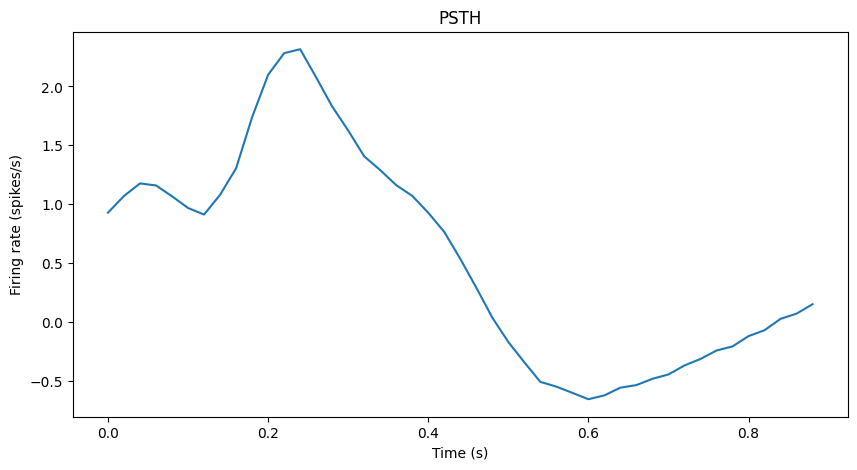

In [1268]:
with torch.no_grad():
    n_bins = n_time_bins
    bin_size = cfg.bin_sz  # Assuming bin size of 10 ms

    # trials x time bins
    single_neuron = r_s[0, :, :, 0]

    # Calculate the PSTH by averaging across trials
    psth = torch.mean(single_neuron, axis=0)

    # Create a time vector for plotting
    time_bins = np.arange(n_bins) * bin_size

    # Plot the PSTH
    plt.figure(figsize=(10, 5))
    plt.plot(time_bins, psth)

    plt.xlabel('Time (s)')
    plt.ylabel('Firing rate (spikes/s)')
    plt.title('PSTH')
    plt.show()

In [1274]:
y_test_obs[:, :, 0].shape

torch.Size([287, 45])

In [1288]:
torch.mean(y_test_obs[:, :, 0], axis=0) / bin_size

tensor([2.7875, 3.4843, 3.6585, 6.2718, 8.5366, 7.4913, 6.6202, 8.1882, 5.7491,
        4.0070, 5.2265, 4.5296, 2.4390, 2.2648, 2.6132, 2.0906, 1.2195, 0.8711,
        0.8711, 0.8711, 0.5226, 0.8711, 0.8711, 0.3484, 0.3484, 0.5226, 0.1742,
        0.0000, 0.1742, 0.3484, 0.5226, 0.3484, 0.5226, 0.3484, 0.5226, 0.1742,
        0.1742, 0.1742, 0.1742, 0.0000, 0.0000, 0.0000, 0.1742, 0.0000, 0.0000])

In [3050]:
def generate_unique_random_ints(mn, mx, n):
    
    unique_numbers = []
    
    while len(unique_numbers) < n:
        number = random.randint(mn, mx)
        
        if number not in unique_numbers:
            unique_numbers.append(number)
            
    return unique_numbers


def calculate_data_psth(trials, neurons=[0, n_neurons_obs//4, n_neurons_obs//4 + n_neurons_obs//2, n_neurons_obs-1]):
    
    n_bins = n_time_bins
    bin_size = cfg.bin_sz  # Assuming bin size of 10 ms
    
    psths = []

    # trials x time bins
    for neuron in neurons:
    
        single_neuron = trials[:, :, neuron]

        # Calculate the PSTH by averaging across trials
        psth = torch.mean(single_neuron, axis=0) / bin_size
        psths.append(psth)
        
    return np.array(psths)


def calculate_model_psth(trials, sample=0, neurons=[0, n_neurons_obs//4, n_neurons_obs//4 + n_neurons_obs//2, n_neurons_obs-1]):
    
    n_bins = n_time_bins
    bin_size = cfg.bin_sz  # Assuming bin size of 10 ms
    
    psths = []
    
    with torch.no_grad():

        # trials x time bins
        for neuron in neurons:
            single_neuron = trials[sample, :, :, neuron]

            # Calculate the PSTH by averaging across trials
            psth = torch.mean(single_neuron, axis=0)
            psths.append(psth)
        
    return np.array(psths)

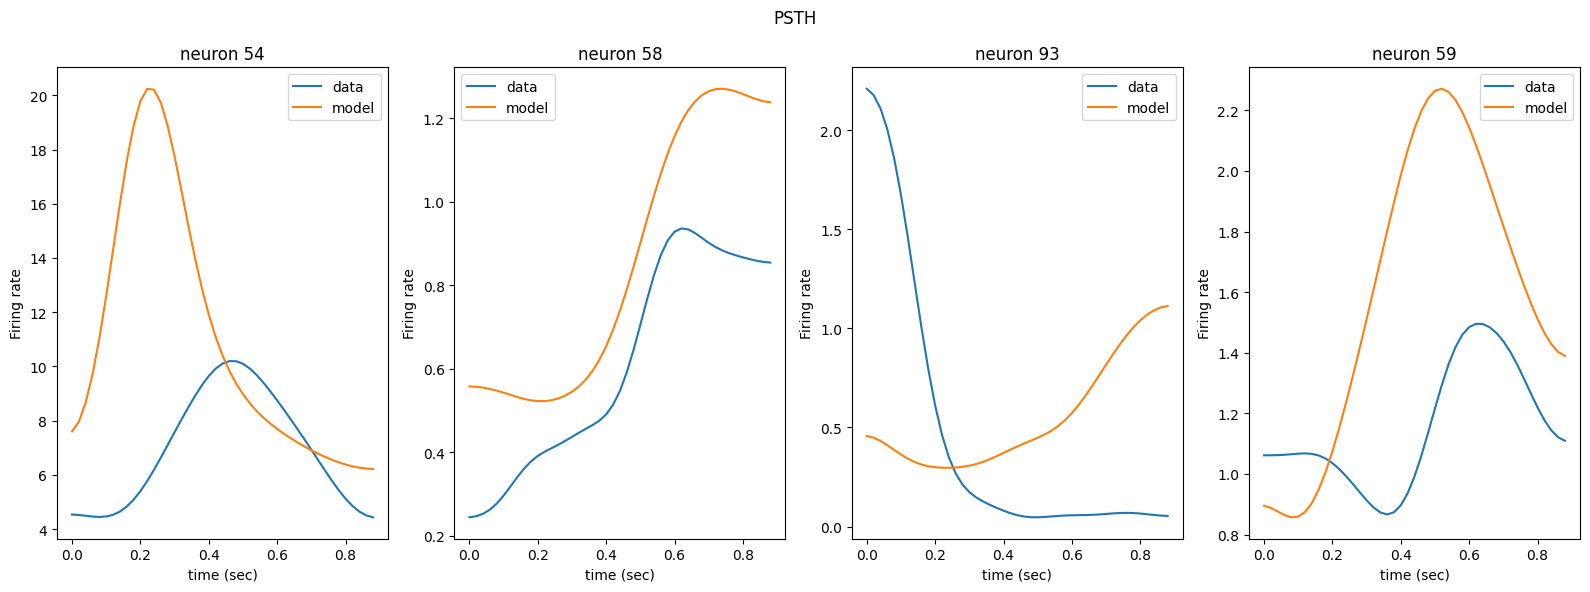

In [1864]:
sample = 10
n_neurons_to_plot = 4
neurons=generate_unique_random_ints(0, n_neurons_obs-1, n_neurons_to_plot)

data_psths = calculate_data_psth(y_test_obs, neurons)
model_psths = calculate_model_psth(torch.exp(r_s), sample, neurons) 

data_psths = torch.tensor(gaussian_filter1d(data_psths, sigma=4, axis=1))
# psth sampled from generative model
model_psths = torch.tensor(gaussian_filter1d(model_psths, sigma=4, axis=1))
            
# Create a time vector for plotting
time_bins = np.arange(n_bins) * bin_size

# Plot the PSTH
fig, axes = plt.subplots(ncols=n_neurons_to_plot, figsize=(16, 6))

fig.tight_layout()
fig.suptitle('PSTH')

for i, ax in enumerate(axes.flat):
    ax.plot(time_bins, data_psths[i], label='data')
    ax.plot(time_bins, model_psths[i], label='model')
    
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('Firing rate')
    ax.set_title(f'neuron {neurons[i]}')
    ax.legend()

plt.tight_layout()
fig.savefig('plots/psth.png', bbox_inches='tight', transparent=True)
plt.show()

In [1826]:
model_rates = cfg.bin_sz * torch.exp(r_s)

In [1828]:
model_rates.shape

torch.Size([25, 287, 45, 182])

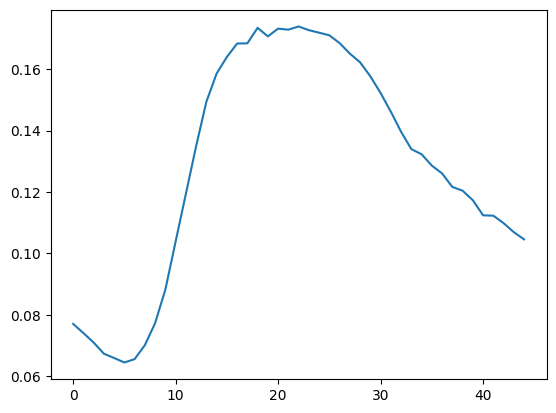

In [1856]:
with torch.no_grad():
    plt.plot(torch.mean(model_rates[0, :, :, 56], dim=0))

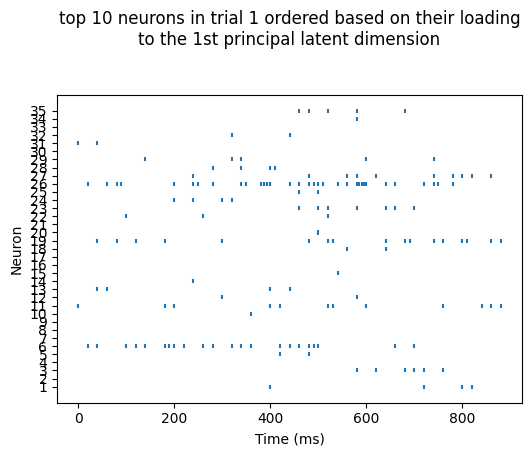

In [4288]:
import matplotlib.pyplot as plt
import numpy as np

num_neurons = n_neurons_obs
num_bins = n_time_bins
bin_duration_ms = cfg.bin_sz_ms  # duration of each time bin in milliseconds

spiking_neurons = order_neurons(y_valid_obs, z_s_test, trial=0, latent=0)[1]

spike_counts = np.array(y_valid_obs[0].T[spiking_neurons[:35], :]).astype('int')[::-1, :]

# Convert spike counts to spike times
spike_times = []
for neuron_id, counts in enumerate(spike_counts):
    neuron_spike_times = []
    for bin_id, count in enumerate(counts):
        # Each spike in the bin is assigned a unique time within the bin
        bin_start_time = bin_id * bin_duration_ms
        neuron_spike_times.extend(bin_start_time + np.linspace(0, bin_duration_ms, count, endpoint=False))
    spike_times.append(neuron_spike_times)

# Plot raster plot with spaces between neurons
plt.figure(figsize=(6, 4))
neuron_spacing = 2  # spacing between neurons
for i, neuron_spikes in enumerate(spike_times):
    plt.vlines(neuron_spikes, i * neuron_spacing + 0.5, i * neuron_spacing + 1.5)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.title('top 10 neurons in trial 1 ordered based on their loading\nto the 1st principal latent dimension\n\n')
plt.yticks(np.arange(len(spike_times)) * neuron_spacing + 1, np.arange(1, len(spike_times) + 1))
plt.show()

In [4198]:
spike_counts.shape

(182, 45)

In [4216]:
spiking_data.shape

(182,)

In [4256]:
spike_counts.shape

(35, 45)

In [4316]:
def plot_spikes(spikes, axs):
    
    n_bins = spikes.shape[0]
    n_neurons = spikes.shape[1]

    # fig, axs = plt.subplots(figsize=(6, 3))
    _, indices = torch.sort(spikes.mean(dim=0))
    spikes = spikes[:, indices][..., n_neurons//2:]
    n_neurons = n_neurons//2

    for n in range(n_neurons):
        time_ax = np.arange(n_bins)
        neuron_spikes = spikes[:, n]
        neuron_spikes[neuron_spikes > 0] = 1
        neuron_spikes = neuron_spikes * time_ax
        neuron_spikes = neuron_spikes[neuron_spikes > 0]

        axs.scatter(neuron_spikes, 0.5 * n * np.ones_like(neuron_spikes), marker='o', color='black', s=4,
                    edgecolors='none')

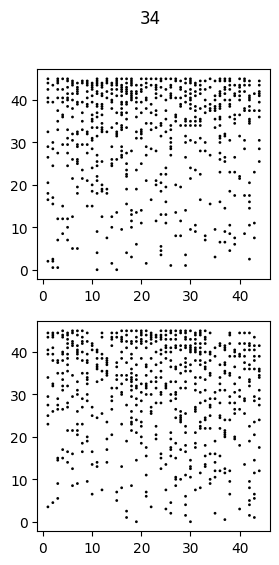

In [4318]:
with torch.no_grad():
    
    fig, axs = plt.subplots(2, 1, figsize=(3, 6))
    plot_spikes(y_test_obs[0].cpu(), axs[0])
    plot_spikes(y_hat[0, 0], axs[1])

    fig.suptitle(i)
    fig.savefig('plots/generated_spikes.svg', bbox_inches='tight', transparent=True)
    plt.show()